Demodulating a Sord 1750Hz/3500Hz variant of the Kansas City Standard
=========

The standard medium for distributing personal computer programs in the 8-bit age
was tape &mdash; not the 9-track tape used by mainframes, minis, and Datapoint, but 4-track audio tape.
Much of our cultural heritage from that era as programmers is flaking off of those tapes.
The most common tape format was the [Kansas City Standard](https://en.wikipedia.org/wiki/Kansas_City_Standard)
and its variations.

In the particular variation I'm going to examine here,
used by the Z80-based Sord PC popular in Japan,
a 0 bit was recorded as one cycle of a 1750 Hz triangle wave, 
and a 1 bit was recorded as two cycles of a 3500 Hz triangle wave, 
both starting with a positive-going zero crossing.
A byte is encoded as a 0 start bit, 8 bits of data LSB first (little-endian, like Datapoint),
and 1 stop bit.  This encoding gives 1750 baud, almost six times the speed of
the original 300-baud Kansas City Standard.

The algorithms developed seem to do reasonably well on both some "synthetic" (fake) data and on some waveforms
captured from an actual physical cassette tape.

Constructing a fake signal
---------------------

Let's see what such a signal looks like at 44.1 ksps.

In [1]:
%pylab inline
rcParams['figure.figsize'] = (12, 2)
rcParams['lines.linewidth'] = 0.5

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
fs = 44100   # sampling frequency
f0 = 1750    # frequency of a 0 bit
#f1 = 3500   # frequency of a 1 bit
tb = 1/f0    # time of a bit
sb = fs * tb # samples of a bit
sb


25.200000000000003

25.2 is a fairly round number of samples, differing from an integer by less than 1%,
but this is still enough to cause trouble.

In [3]:
25.2/25

1.008

If we want to synthesize a sampled sequence of tones, we could calculate,
for each sample, which bit it's in, and how far into that bit.
In Python that looks like this for 100 samples:

In [4]:
divmod(arange(100), sb)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]),
 array([ 0. ,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. , 10. ,
        11. , 12. , 13. , 14. , 15. , 16. , 17. , 18. , 19. , 20. , 21. ,
        22. , 23. , 24. , 25. ,  0.8,  1.8,  2.8,  3.8,  4.8,  5.8,  6.8,
         7.8,  8.8,  9.8, 10.8, 11.8, 12.8, 13.8, 14.8, 15.8, 16.8, 17.8,
        18.8, 19.8, 20.8, 21.8, 22.8, 23.8, 24.8,  0.6,  1.6,  2.6,  3.6,
         4.6,  5.6,  6.6,  7.6,  8.6,  9.6, 10.6, 11.6, 12.6, 13.6, 14.6,
        15.6, 16.6, 17.6, 18.6, 19.6, 20.6, 21.6, 22.6, 23.6, 24.6,  0.4,
         1.4,  2.4,  3.4,  4.4, 

A triangle wave looks like this.

53

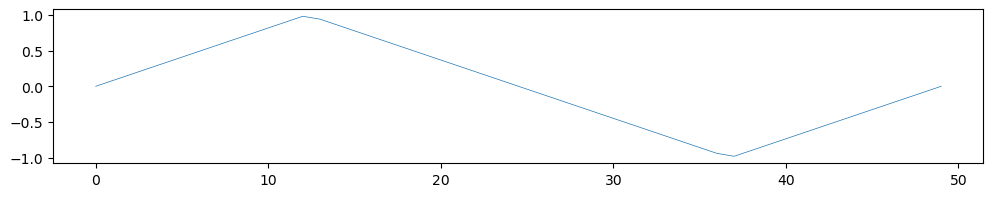

In [5]:
def triw(t):  # t is a fraction from 0.0 to 1.0 indicating where we are in the cycle
    return abs(abs(4*t - 1) - 2) - 1

plot(triw(linspace(0, 1)))
53

53

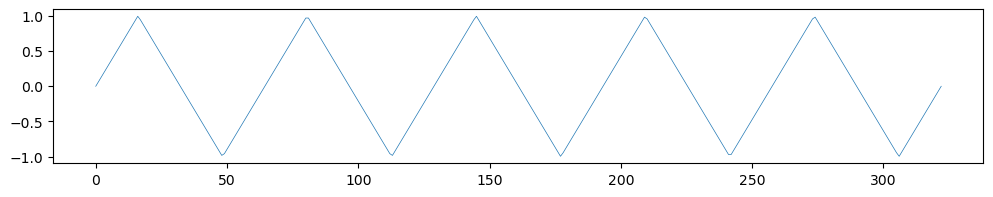

In [6]:
plot(triw(linspace(0, 5, 323) % 1))  # arbitrary number of points makes it imperfect
53

This is like pretty close to a sine wave if you low-pass filter it with an integrator.
But it's not exactly the same.

53

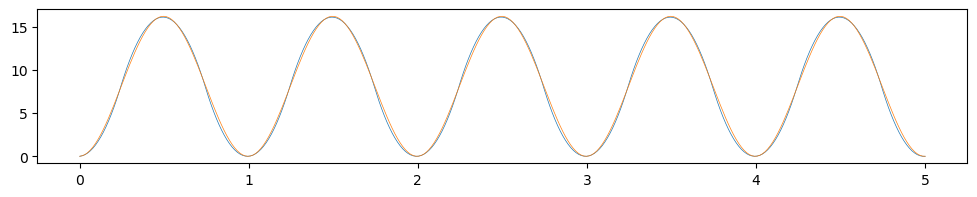

In [7]:
x = linspace(0, 5, 323)
plot(x, triw(x % 1).cumsum())
plot(x, 8.1*(1 - cos(x * 2 * pi + 0.03))) # parameters adjusted by manual fiddling
53

### Turning a message into bits ###

In [8]:
message = 'Hello'
msgary = array([ord(c) for c in message])
msgary

array([ 72, 101, 108, 108, 111])

In [9]:
n_start_bits = 1
stop_bits = 1 << 8 + n_start_bits
bits = (right_shift.outer(msgary << n_start_bits | stop_bits, arange(10))) & 1
bits

array([[0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 1, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 1, 0, 1, 1, 0, 1],
       [0, 1, 1, 1, 1, 0, 1, 1, 0, 1]])

So now we have the bits for our message; we just have to put them in a single array:

In [10]:
br = bits.ravel()
br

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1])

In [11]:
n_samples = int(len(br) * sb)
n_samples

1260

### Turning bits into per-sample frequencies ###

Now we can compute which bit we're transmitting, and which phase within that bit, for each sample.

In [12]:
bitidx, phase = divmod(arange(n_samples), sb)
bitidx, phase

(array([ 0.,  0.,  0., ..., 49., 49., 49.]),
 array([ 0. ,  1. ,  2. , ..., 22.2, 23.2, 24.2]))

We will use this information to set our frequency.

array([1, 1, 1, ..., 2, 2, 2])

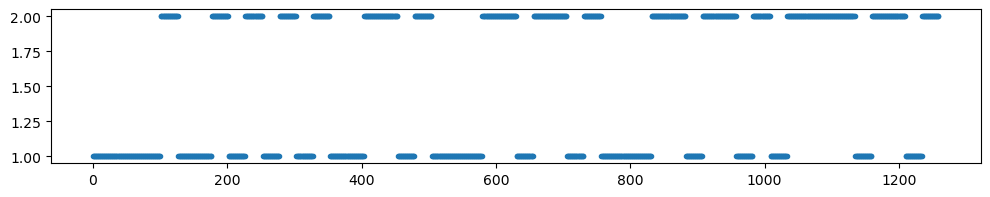

In [13]:
bi = bitidx.astype(int)    # bit index
bf = br[bi] + 1            # bit frequency
plot(bf, '.')
bf

### Turning frequencies into samples ###

Now we have to compute the phase within the triangle wave for each bit.  Remember tri()
expects 0 to 1 for a full cycle, not 0 to $2\pi$.  This looks ragged with the peaks at different heights
because our bit time isn't an integer number of cycles.

array([0.        , 0.03968254, 0.07936508, ..., 0.76190476, 0.84126984,
       0.92063492])

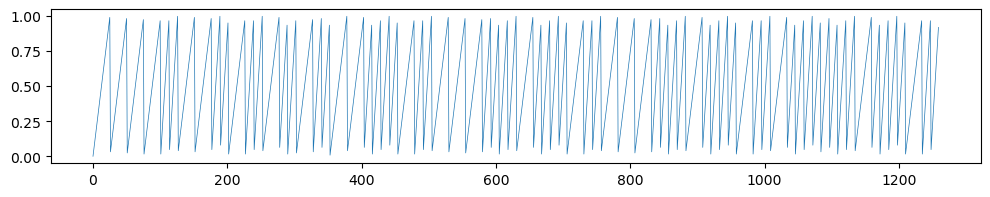

In [14]:
omega = phase * bf / sb % 1
plot(omega)
omega

Let's include some noise, including some dead time at the end.

4.462355405651721

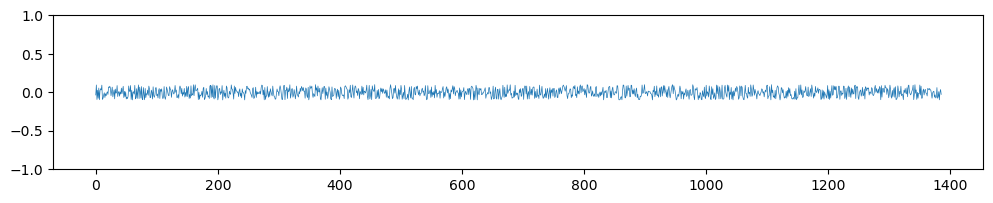

In [15]:
noise = .2 * (random.random(round(len(omega) * 1.1)) - 0.5)
plot(noise)
ylim(-1, 1)
(noise**2).sum()

(419.84580498866296, 4.096287002991773)

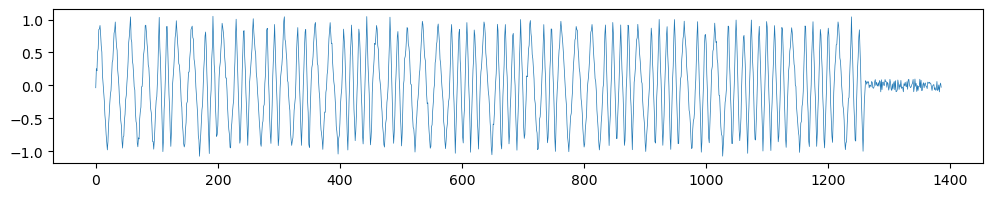

In [16]:
clean_signal = triw(omega)
signal = noise.copy()
signal[:len(clean_signal)] += clean_signal
plot(signal)
(clean_signal**2).sum(), (noise[:len(clean_signal)]**2).sum()

The signal is 20 dB stronger than the noise; it contains 100 times as much power.  Hopefully we can cope with such
a small amount of noise.

Let's look at the frequency response in dB.

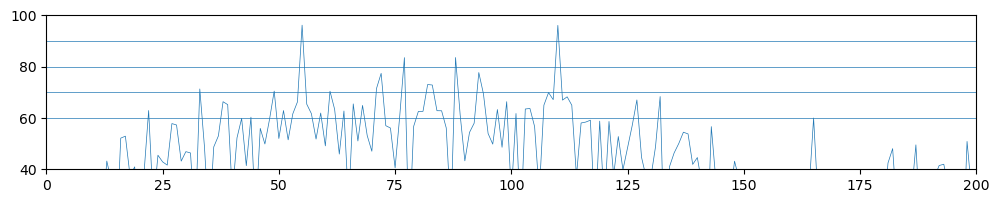

In [17]:
plot(log10(abs(fft.fft(signal)**2))*20)
xlim(0, 200)
ylim(40, 100)
# poor man's grid, I forget how to do this right
for i in range(60, 100, 10):
    axhline(i)

Demodulating with comb filters
-----

To demodulate that, we can try nulling out one frequency or the other.

### Detecting the zero tone ###

Let's start with detecting zeroes.  We can null out the high frequency (1)
by subtracting the signal from itself one cycle ago, which is half a cycle for the low-frequency signal (0).

13

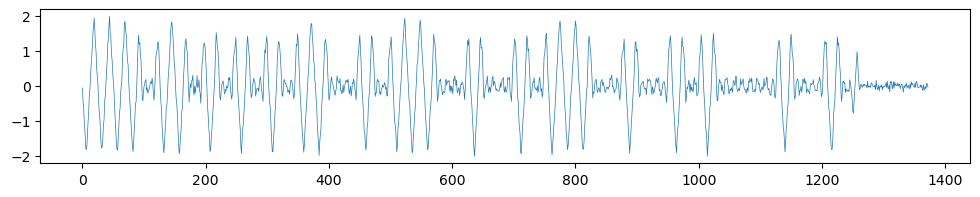

In [18]:
shift = round(sb/2)
plot(signal[shift:] - signal[:-shift])
shift

This is not attenuating the high frequency signal very well because 13 is not a very good approximation to $\frac{25.2}{2}$.
It's wrong by about 3%, and as it turns out, that means 3% of the signal leaks through.

In [19]:
sb/2, (13-sb/2)/13

(12.600000000000001, 0.03076923076923066)

We can do better with a fractional delay filter.  We interpolate the signal 12.6 samples ago as $y(n) = 0.6 x(n - 13) + 0.4 x(n - 12)$.  This is not quite an allpass filter because it has a significant low-pass characteristic,
but its threshold frequency is high enough that we probably don't care.

array([ 0.08044392,  0.2415412 ,  0.33531454, ..., -0.05806454,
        0.01563948,  0.01065796])

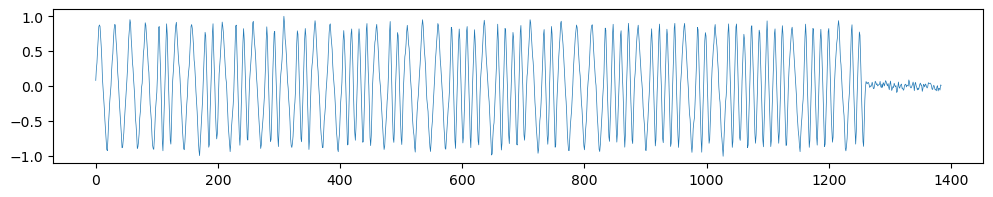

In [20]:
fd = 0.6 * signal[:-1] + 0.4 * signal[1:]
plot(fd)
fd

array([-0.17899225, -0.46956484, -0.78444362, ...,  0.05185719,
        0.03793956, -0.03746053])

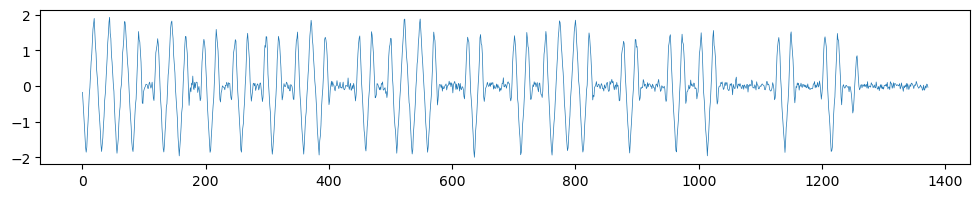

In [21]:
zr = signal[13:] - fd[:-12]   # zero-detecting signal, raw
plot(zr)
zr
     

This is pretty good, even if on its own it falls short of the 60 dB of separation we might wish for.  We can
low-pass filter it a bit, which will probably help with the remaining noise:

array([-98.87454364, -36.17619681,  28.22176478, ..., -10.16374552,
       -10.9671781 , -11.22710761])

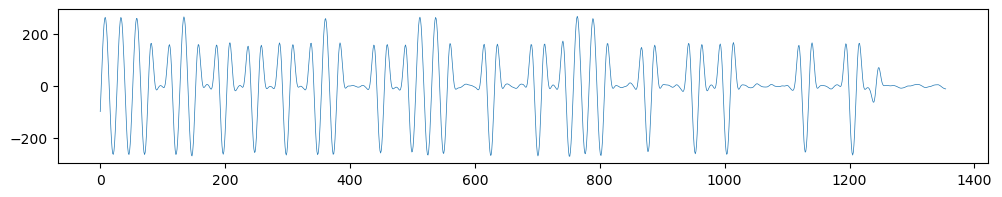

In [22]:
zrs = zr.cumsum()   # zr sum
zbf = zrs[6:] - zrs[:-6]  # zero box filter
zbfrs = zbf.cumsum()
zlf = zbfrs[6:] - zbfrs[:-6] # zero linear filter
zlfrs = zlf.cumsum()
zpf = zlfrs[6:] - zlfrs[:-6] # zero parabolic filter
plot(zpf)
zpf

We've lost a whole cycle off the beginning at this point, which might be a problem;
the tapes were typically recorded with a long pilot tone, plus pilot tones between blocks,
in part because problems like this happen in analog electronics too.

Let's see about squaring the signal to get the signal power we've detected in zero bits.
Note that this is the first step that isn't linear and time-invariant.

array([9776.17537974, 1308.71721542,  796.46800752, ...,  103.30172303,
        120.27899556,  126.0479453 ])

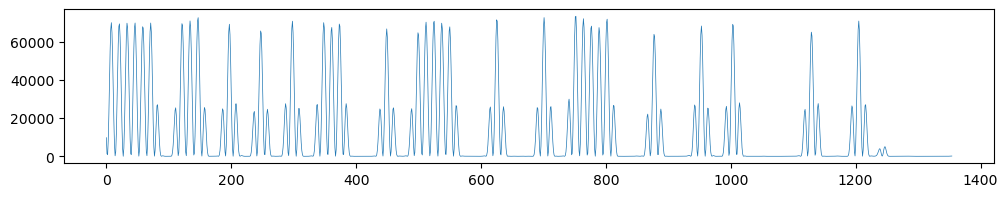

In [23]:
zpr = zpf**2   # zero power, raw
plot(zpr)
zpr

This is good, but it still drops down to zero at every zero crossing of the original waveform.  Remember $\sin^2 \theta = \frac 12 + \frac 12 \cos(2\theta)$; if we want to cancel out the oscillation, we can shift by half a cycle
and add.
Half a cycle in this case is 6.3 samples; again this benefits from a fractional-delay filter, though in this case that's less important.

array([70681.38748047, 71220.90279445, 70931.71935345, ...,
         104.07551898,   124.86404466,   141.38173422])

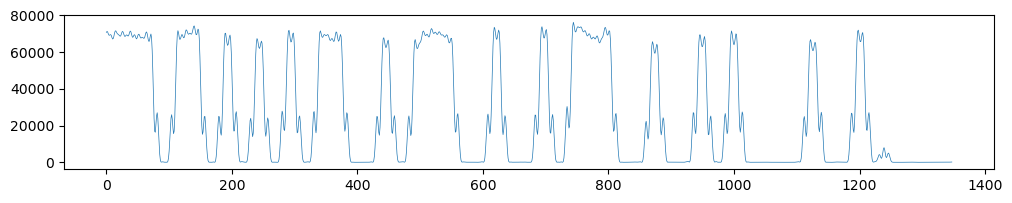

In [24]:
zps = zpr[7:] + 0.7 * zpr[1:-6] + 0.3 * zpr[:-7]  # zero power smoothed
plot(zps)
zps

It's less important because at this point we can box-filter over
half a bit-time to get a nice peak in the middle of each
isolated 0 bit,
which is the optimal filter for fast transitions at a given level of noise suppression,
and which takes care of most of those oscillations.
Note that we've lost two whole bits off the beginning to all this filtering.

array([8.99438208e+05, 8.99588548e+05, 9.00209175e+05, ...,
       5.87152826e+02, 6.84538106e+02, 7.92862404e+02])

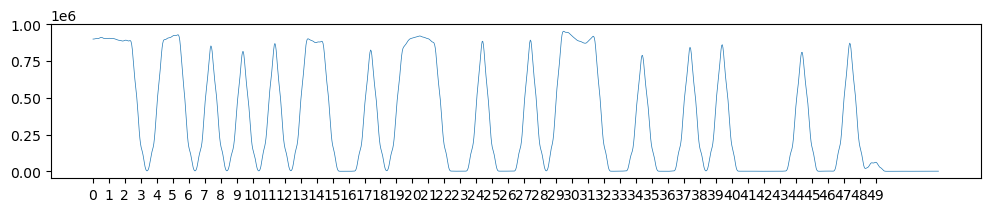

In [25]:
zpss = zps.cumsum()   # zero power smoothed sum
zd = zpss[13:] - zpss[:-13]
plot(arange(len(zd))/sb, zd)
xticks(arange(50))
zd

### Detecting the ones' tone ###

We want to detect the ones, too, because we can't assume that any silence is a 1.
We can comb-filter out the zero frequency by adding the delayed signal instead of subtracting:

array([-0.01810441,  0.01351756, -0.11381455, ..., -0.04769554,
        0.0340154 , -0.01718209])

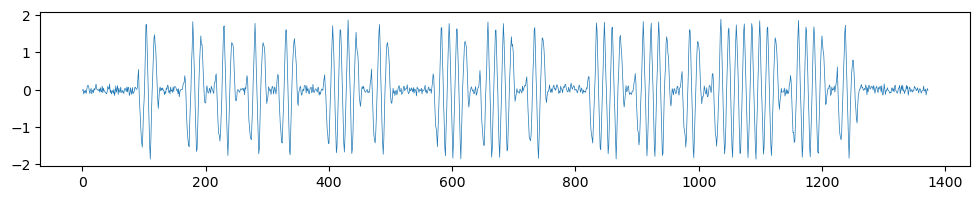

In [26]:
odr = signal[13:] + fd[:-12]   # one-detecting signal, raw
plot(odr)
odr

The same kind of low-pass filtering is probably advisable, though it'll attenuate this signal more:

array([ 1.93244479,  0.34636342, -1.75251037, ..., -3.69596454,
       -3.66729314, -3.58097385])

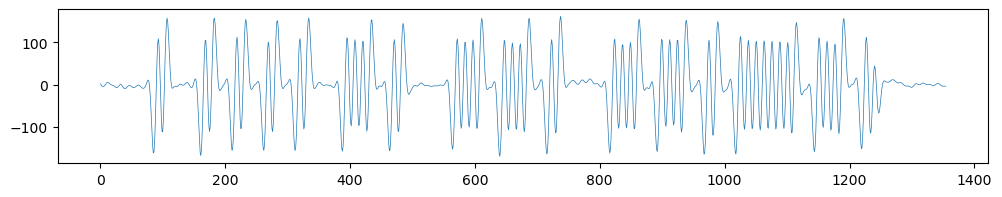

In [27]:
odrs = odr.cumsum()   # odr sum
odbf = odrs[6:] - odrs[:-6]  # one-detection box filter
odbfrs = odbf.cumsum()
odlf = odbfrs[6:] - odbfrs[:-6]  # one-detection linear filter
odlfrs = odlf.cumsum()
odpf = odlfrs[6:] - odlfrs[:-6]  # one-detection parabolic filter
plot(odpf)
odpf

array([ 3.73434287,  0.11996762,  3.07129261, ..., 13.66015389,
       13.44903901, 12.82337371])

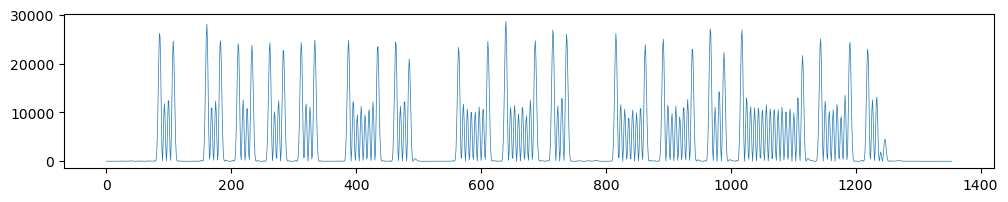

In [28]:
opr = odpf**2   # ones' power, raw
plot(opr)
opr

I'm not sure why it has those cat ears.

This time, to fill in the zeroes, we want to shift by half as much, 3.15 samples.

array([21.34728442, 24.21872694, 26.4082723 , ..., 26.03256229,
       27.14621298, 26.94177395])

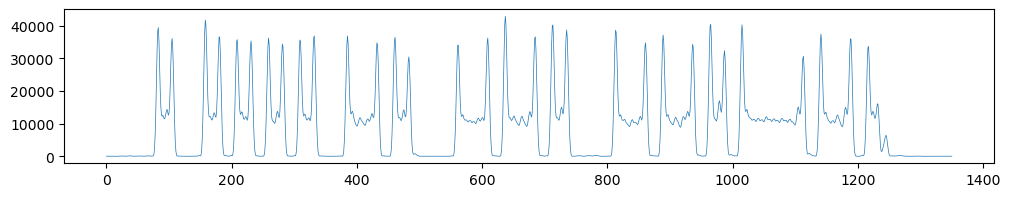

In [29]:
ops = opr[4:] + 0.15 * opr[:-4] + 0.85 * opr[1:-3]  # ones' power, smoothed
plot(ops)
ops

array([342.02104634, 324.84902821, 301.65502025, ..., 152.33884919,
       173.43451807, 192.3841714 ])

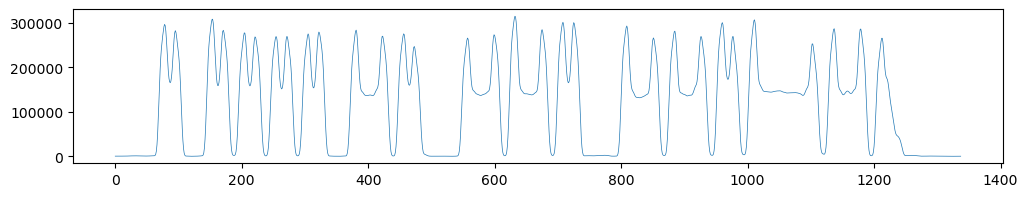

In [30]:
opss = ops.cumsum()
od = opss[13:] - opss[:-13]
plot(od)
od

We filtered off a few more samples at the beginning from the zero-bit detection.

In [31]:
len(od), len(zd)

(1338, 1335)

Also there's a scalar amplification factor due to not dividing by the box length in those box filters.

In [32]:
zd.sum() / od.sum()

2.8810901526309713

array([-8.98319079e+05, -8.98469419e+05, -8.99090046e+05, ...,
        5.31976460e+02,  4.34591179e+02,  3.26266881e+02])

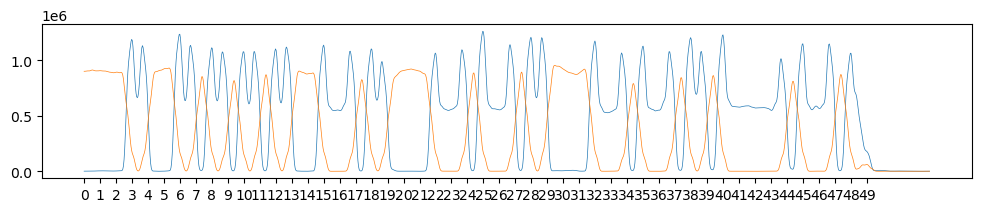

In [33]:
d = len(od) - len(zd)
plot(arange(len(zd)) / sb, od[d:] * 4)
plot(arange(len(zd)) / sb, zd)
xticks(arange(50))
od[3] * 4 - zd

I was maybe hoping for an eye diagram, but that's a nice kittycat diagram.

### Improving the detection of the ones' tone ###

I think one problem with the ones filter is that it's not very selective.  A particularly egregious example
is that it has nonzero response at dc.  A better version would include a negative-feedforward comb filter
with a zero dc component with some selectivity for the frequency we want, which is 3500 Hz.  That's 12.6
samples per oscillation, and thus 6.3 samples between peaks and troughs.


In [34]:
44100/3500

12.6

array([-0.00115959,  0.18491364,  0.17289419, ..., -0.02345885,
       -0.02817646, -0.02254635])

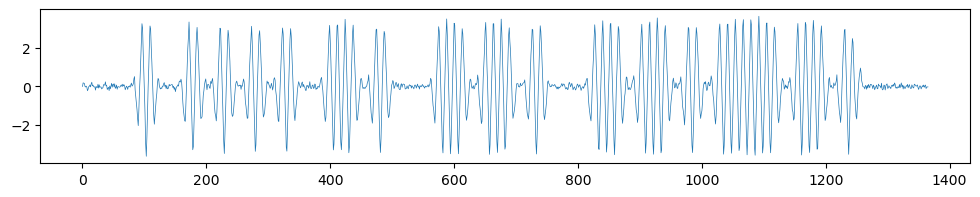

In [35]:
odb = odr[7:] - 0.3 * odr[:-7] - 0.7 * odr[1:-6]   # ol' dirty bastard
plot(odb)
odb

array([-3.17881494,  0.98376481,  5.23902712, ..., -3.02298725,
       -1.96526   , -0.86481772])

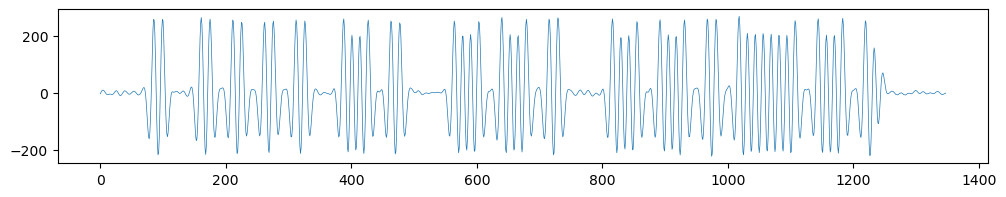

In [36]:
def boxfilter(signal, n):
    s = signal.cumsum()
    return s[n:] - s[:-n]

odbpf = boxfilter(boxfilter(boxfilter(odb, 6), 6), 6)
plot(odbpf)
odbpf

array([ 93.96968203, 110.47764659, 118.12412658, ...,  45.18915384,
        32.27485864,  19.47376144])

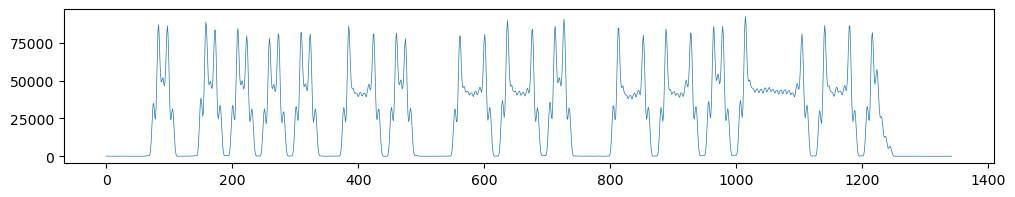

In [37]:
odbpr = odbpf**2
odbps = odbpr[4:] + 0.15 * odbpr[:-4] + 0.85 * odbpr[1:-3]  # ones' detection better power, smoothed
plot(odbps)
odbps

In [38]:
bod = boxfilter(odbps, 13)
len(zd), len(bod)

(1335, 1331)

array([893.15190097, 832.46142498, 764.58890622, ..., 427.95735251,
       440.25285457, 431.44373483])

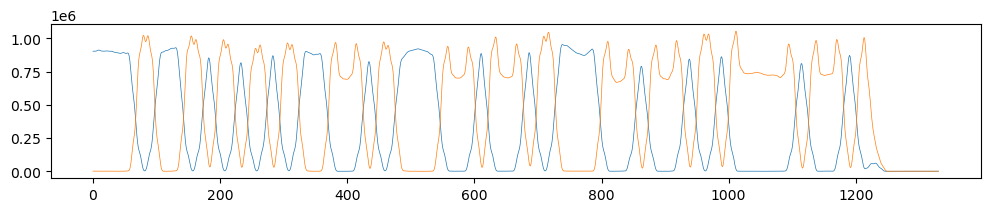

In [39]:
plot(zd[4:])
plot(bod * 1.3)
bod

I think that looks a little better.

### Noise response ###

We can zoom in on that last little bit to see what the response to noise looks like.  It's mostly about 1000
times lower than the response to the signal, which represents 30 dB (since we're looking at powers here).
Given that the signal was 20 dB above the noise, this is not great; it's only 10 dB of improvement.

array([21291., 14700.,  8872.,  4589.,  2048.,   862.,   448.,   370.,
         399.,   455.,   515.,   562.,   592.,   600.,   584.,   550.,
         508.,   477.,   465.,   466.,   477.,   496.,   518.,   527.,
         533.,   539.,   540.,   540.,   540.,   544.,   550.,   548.,
         526.,   487.,   433.,   365.,   312.,   299.,   314.,   353.,
         418.,   491.,   547.,   581.,   593.,   591.,   585.,   579.,
         573.,   560.,   523.,   465.,   398.,   326.,   260.,   213.,
         185.,   175.,   182.,   196.,   204.,   201.,   189.,   172.,
         159.,   146.,   136.,   130.,   121.,   112.,   108.,   108.,
         111.,   127.,   153.,   178.,   202.,   224.,   240.,   257.,
         283.,   319.,   359.,   398.,   428.,   440.,   431.])

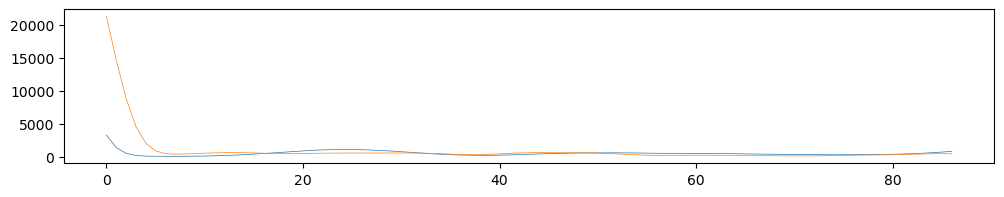

In [40]:
plot(zd[-87:])
plot(bod[-87:])
bod[-87:].round()

Crating up the filters for shipping
-----

I think it's worth breaking out the LTI parts of these filters to see what their impulse response is.

In [41]:
def zero_parabolic(signal, sd=6):
    fd = 0.6 * signal[:-1] + 0.4 * signal[1:]
    return boxfilter(boxfilter(boxfilter(signal[13:] - fd[:-12], sd), sd), sd)

((zero_parabolic(signal) - zpf)**2).max()

0.0

We can see that it's a pretty close replication of a single cycle of the sine wave we're looking for.

array([  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   1. ,   3. ,   6. ,  10. ,  15. ,  21. ,  25. ,  27. ,
        27. ,  25. ,  21. ,  15. ,   9.6,   4.2,  -1.2,  -6.6, -12. ,
       -17.4, -22.6, -25.8, -27. , -26.2, -23.4, -18.6, -13. ,  -8.4,
        -4.8,  -2.2,  -0.6,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ])

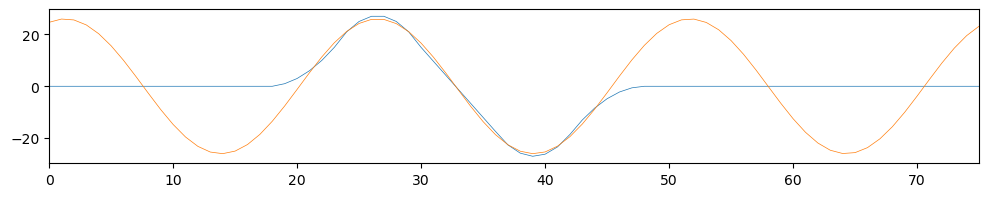

In [42]:
impulse = zeros(500)
impulse[50] = 1
plot(zero_parabolic(impulse))
#plot(23*sin(arange(len(impulse))*2*pi/sb + 1.6))  # closer when sd=7
plot(26*sin(arange(len(impulse))*2*pi/sb + 1.25))
xlim(0, 75)
zero_parabolic(impulse)[:75]

In [43]:
def ones_parabolic(signal, sd=6):
    fd = 0.6 * signal[:-1] + 0.4 * signal[1:]
    odr = signal[13:] + fd[:-12]
    odb = odr[7:] - 0.3 * odr[:-7] - 0.7 * odr[1:-6]   # ol' dirty bastard
    return boxfilter(boxfilter(boxfilter(odb, sd), sd), sd)

((ones_parabolic(signal) - odbpf)**2).max()

0.0

A couple of efficiency notes here:

* If you're calculating 0.6 times a signal, you can calculate 0.4 times the signal without firing up the multiplier
  a second time.  Likewise 0.7 and 0.3.
* The initial fractional-delay filter can be shared between the zeroes and the ones.
* Because this is all LTI, all the filtering stages commute, so we could also move the low-pass filtering
  with box filters to the beginning, too.  That would allow the zeroes and ones to share them, too.
* Probably it would be useful to decimate the signal a bit once you've low-pass filtered it, even if that requires
  more elaborate fractional-delay filters to get the same performance, because you're handling maybe one fourth
  as many samples.

array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   3.  ,   6.  ,  10.  ,
        15.  ,  21.  ,  24.3 ,  24.6 ,  21.9 ,  16.2 ,   7.5 ,  -4.2 ,
       -13.4 , -18.6 , -19.8 , -17.  , -10.2 ,   0.6 ,  10.82,  17.22,
        19.62,  18.02,  12.42,   2.82,  -8.04, -16.44, -21.84, -24.24,
       -23.64, -20.04, -14.68,  -9.78,  -5.88,  -2.98,  -1.08,  -0.18,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ])

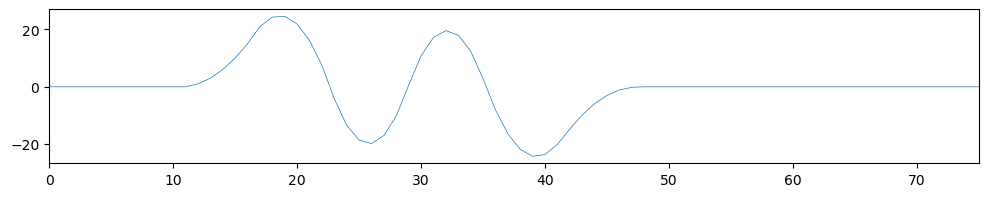

In [44]:
plot(ones_parabolic(impulse)); xlim(0, 75)
ones_parabolic(impulse)[:75]

Well, maybe that's where our kitty ears are coming from.  The peaks in the middle are getting attenuated by the other peaks spreading into them too much.  Can we fix that?

array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   1.  ,   3.  ,   6.  ,  10.  ,  12.  ,  12.  ,
         9.3 ,   3.6 ,  -2.1 ,  -7.8 , -11.4 , -12.  , -10.2 ,  -5.4 ,
         0.3 ,   6.  ,  10.5 ,  12.  ,  10.92,   7.02,   1.32,  -4.38,
        -9.24, -11.64, -11.44,  -9.24,  -5.88,  -2.98,  -1.08,  -0.18,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ])

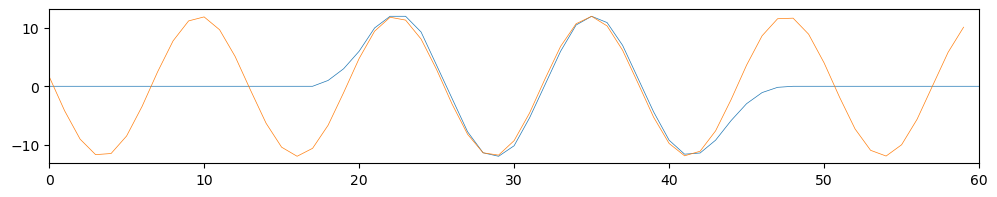

In [87]:
plot(ones_parabolic(impulse, 4))
plot(12*sin(2*arange(60)*2*pi/sb+3))
xlim(0, 60)
ones_parabolic(impulse, 4)[:60]

That does look better.  Can we compare that to the original?  Well, we haven't neatly packaged up
the stuff past the squaring yet,
but this looks promising:

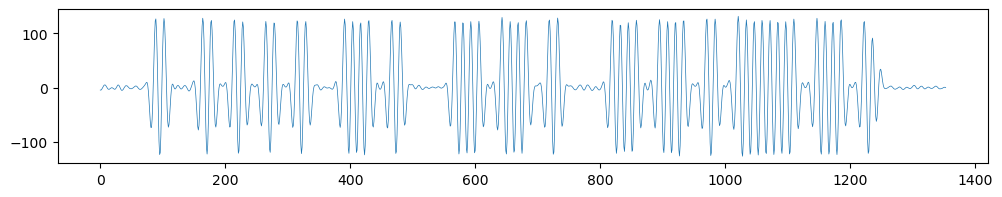

In [46]:
plot(ones_parabolic(signal, 4))
None

In [47]:
def filter_zero_power(zpr):
    return boxfilter(zpr[7:] + 0.7 * zpr[1:-6] + 0.3 * zpr[:-7], 13)

def filter_ones_power(opr):
    return boxfilter(opr[4:] + 0.15 * opr[:-4] + 0.85 * opr[1:-3], 13)

zrep = filter_zero_power(zero_parabolic(signal)**2)
orep = filter_ones_power(ones_parabolic(signal, 4)**2)
len(zrep), len(orep)

(1335, 1337)

array([254.53685193, 240.08964123, 219.88490352, ...,  79.93764156,
        72.71837655,  65.39345586])

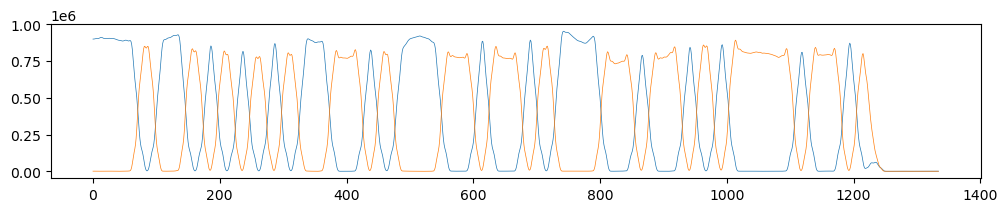

In [48]:
plot(zrep)
plot(orep[2:]*4)
orep

That doesn't totally eliminate the cat ears, but it does seem to cut them down a lot.

What if the speed is wrong?
---------

These filters are like *extremely* unselective in frequency.  The low-frequency filter has to recognize
*one cycle*, for Christ's sake.  The only reason it can reliably reject the other signal *an entire octave away*
is that it has a *purposely designed null* in its frequency response there.  Let's look at what these frequency
responses look like:

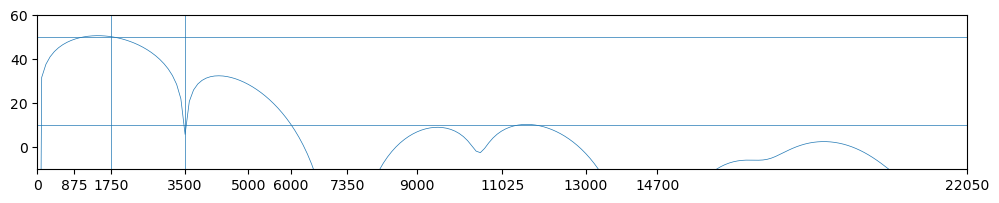

In [49]:
def plot_freq_resp(fr):
    plot(arange(441)*100, log10(abs(fr)**2)*10)
    xticks([0, 875, 1750, 3500, 5000, 6000, 7350, 9000, 11025, 13000, 14700, 22050])
    xlim(0, 22050)
    ylim(-10, 60)
    axvline(3500)
    axvline(1750)
    
zfr = fft.fft(zero_parabolic(impulse)[:441])  # zeroes' frequency response
axhline(50); axhline(10)
plot_freq_resp(zfr)

It's a pretty decent null, about 50 dB I think.  There's an even better null at 0,
and others at 7350 Hz and 14700 Hz,
which are due to the width-6 box filters we're using for low-pass filtering.
But basically everything around a kilohertz or two is the same to this filter.  Let's try it on a frequency sweep:

array([1.28228272e-01, 2.56962585e-01, 3.86202942e-01, ...,
       1.26575602e+03, 1.26689532e+03, 1.26803513e+03])

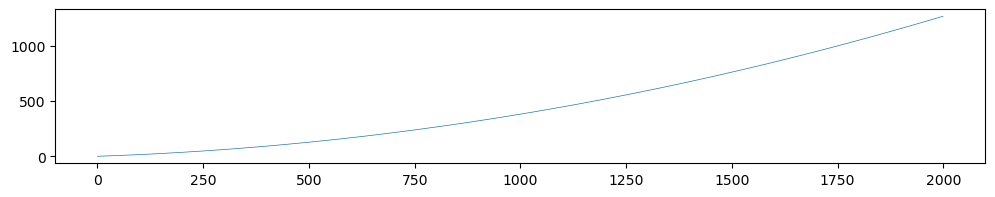

In [50]:
sweepfreq = linspace(900, 8000, 2000)   # 2000 samples
phasedelta = sweepfreq * 2 * pi / 44100
phaseaccum = phasedelta.cumsum()
plot(phaseaccum)
phaseaccum

array([ 0.12787716,  0.25414404,  0.37667375, ...,  0.30107242,
       -0.740278  , -0.9200868 ])

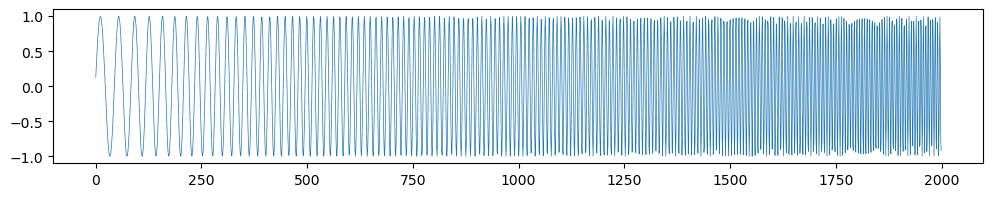

In [51]:
sweep = sin(phaseaccum)
plot(sweep)
sweep

53

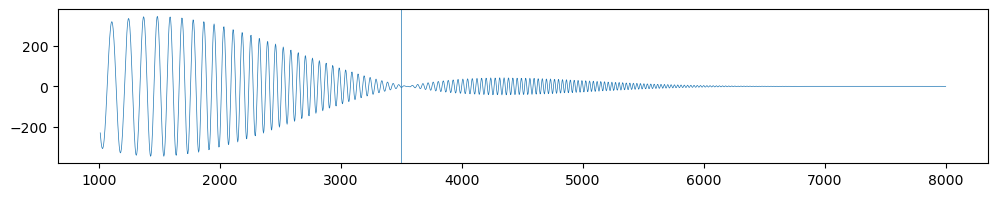

In [52]:
response = zero_parabolic(sweep)
plot(sweepfreq[len(sweepfreq)-len(response):], response)
axvline(3500)
53

So actually what we should be worried about 
with tape speed errors
is not that the low-frequency filter will *miss* the low frequency,
but that it will *accidentally also include* the high frequency.  And probably *mutatis mutandis*:

53

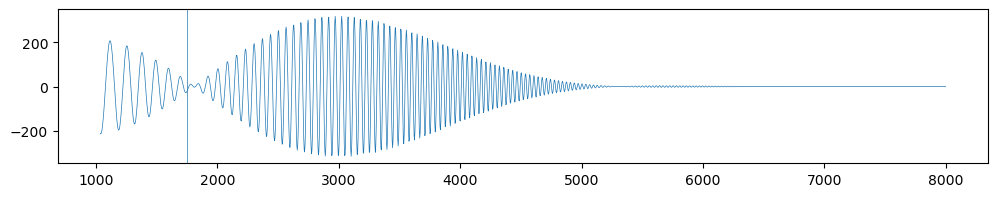

In [53]:
rone = ones_parabolic(sweep)
plot(sweepfreq[len(sweepfreq)-len(rone):], rone)
axvline(1750)
53

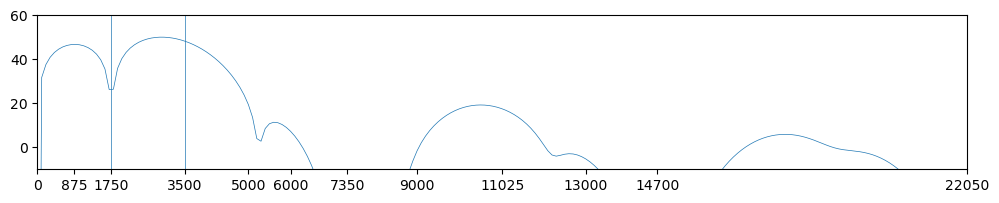

In [54]:
plot_freq_resp(fft.fft(ones_parabolic(impulse)[:441]))

So let's make a version of the signal that's, say, 5% slow.
It'll be lame, we'll just duplicate every 20th sample, but that's probably fine.

array([-0.03500408,  0.25361592,  0.22342912, ...,  0.00208082,
        0.03597748, -0.02732131])

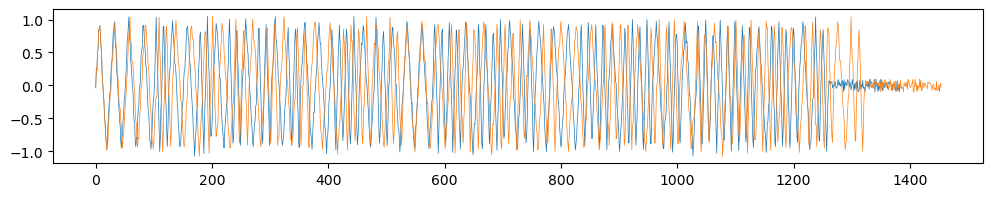

In [55]:
slowsig = zeros(int(len(signal) * 1.05))
for i in range(20):
    slowsig[i::21] = signal[i::20]
slowsig[20::21] = signal[20::20]
plot(signal)
plot(slowsig)
slowsig

In [56]:
zreps = filter_zero_power(zero_parabolic(slowsig)**2)
oreps = filter_ones_power(ones_parabolic(slowsig, 4)**2)
len(zreps), len(oreps)

(1404, 1406)

array([1724.50424944, 1643.59785806, 1538.14295242, ...,   75.19384271,
         69.14477412,   65.40954251])

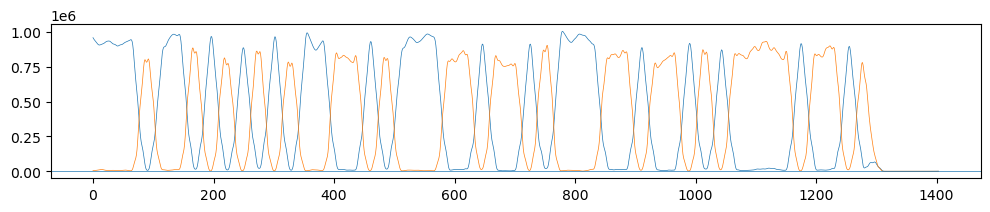

In [57]:
plot(zreps)
plot(oreps[2:] * 4)
axhline(0)
oreps

I feel like that is probably acceptable.  How about 20% fast?

array([-0.03500408,  0.25361592,  0.22342912, ...,  0.00872719,
       -0.09816146,  0.00208082])

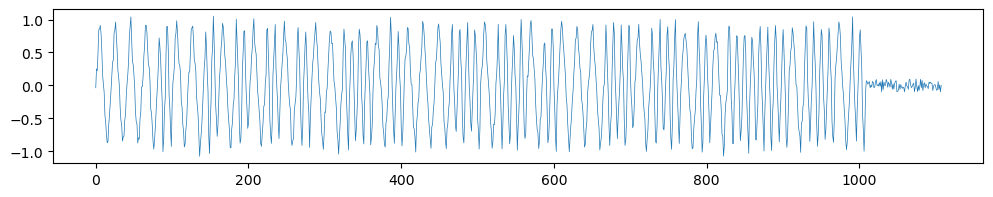

In [58]:
fastsig = zeros(int(len(signal)*.8))
for i in range(4):
    fastsig[i::4] = signal[i::5][:(len(fastsig)-i+3)//4]
plot(fastsig)
fastsig

In [59]:
zrepf = filter_zero_power(zero_parabolic(fastsig)**2)
orepf = filter_ones_power(ones_parabolic(fastsig, 4)**2)
len(zrepf), len(orepf)

(1057, 1059)

array([33425.3284718 , 31160.05618581, 29240.05697022, ...,
          91.83376066,    98.05558109,   105.09491398])

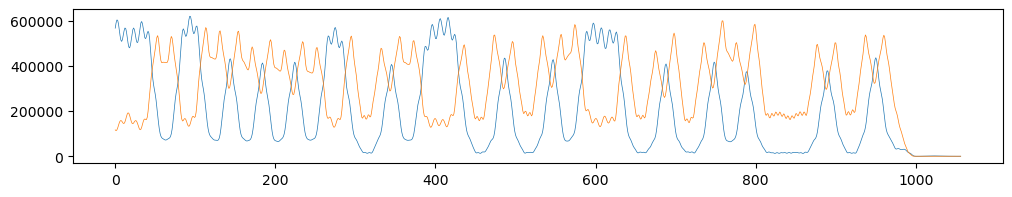

In [60]:
plot(zrepf)
plot(orepf[2:]*4)
orepf

That's pretty ugly, but it still seems to have successfully recovered all of the bit transitions with
my seat-of-the-pants factor of 4.

Plausibly a better solution for this kind of problem would be to use a PLL to track the fundamental frequency.

Cleaning up the data with FIR filtering
-------------

We might be able to design a FIR filter that has a much wider stopband, though, without needing more than 25 taps.
Any support in the impulse response of more than about 25 taps is probably counterproductive.

We can ask for a FIR filter with a given frequency response by
drawing the frequency response in the frequency
domain, and then Fourier transforming it.  Ideally we'd like to have equal gain for both our target frequencies,
but suppress noise in the band in between.

If we put 44100 frequencies in our array of frequency response, array indices
will conveniently correspond to signal component frequencies in Hz.

array([0., 0., 0., ..., 0., 0., 0.])

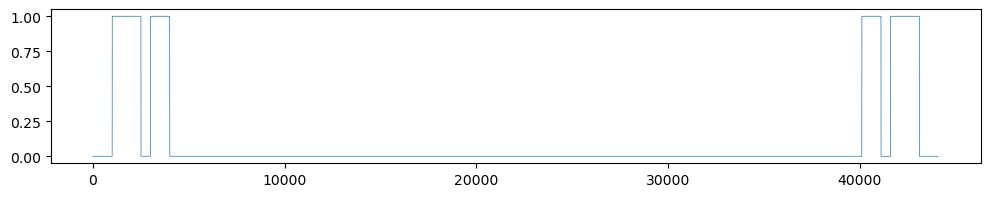

In [61]:
desired = zeros(44100)
desired[1000:2500] = 1                 # We want flat response here, for the zero tone
desired[3000:4000] = 1                 # and here, for the ones' tone
desired[22051:] = desired[22049:0:-1]  # We have to make the frequency response symmetric for a real filter kernel
plot(desired)
desired

Let's see what impulse response such a frequency response would transform to in the time domain.

(44000.0, 44100.0)

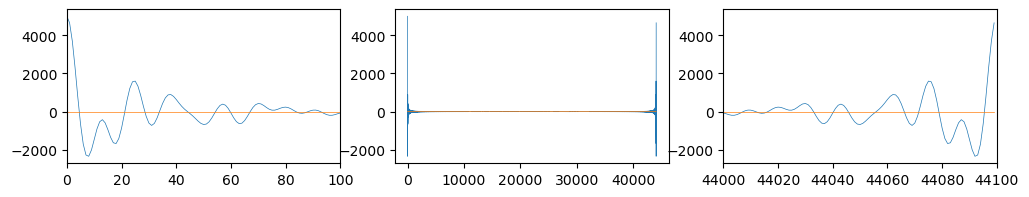

In [62]:
dtd = fft.fft(desired)  # desired time domain response
subplot(131); plot(dtd.real); plot(dtd.imag); xlim(0, 100)
subplot(132); plot(dtd.real); plot(dtd.imag)
subplot(133); plot(dtd.real); plot(dtd.imag); xlim(44000, 44100)

We can see that its imaginary part in the time domain is zero because we made its frequency response symmetric.
This is useful because the signal you read off a cassette tape doesn't have an imaginary part,
so you'd better not be depending on it to get the right results.
(I/Q signals used in SDR do, though.)

Also, we can see that it's pretty close to zero everywhere except at small time shifts, which is because it
extends over a wide range of frequencies.

Finally, we can see that it's symmetrical in time, which is (reciprocally) because its frequency response
doesn't have an imaginary part.

We can literally just take that impulse response and convolve it with our signal in the time domain to filter it.
But it's convenient to approximate the impulse response with a small segment around zero,
so that we don't have to do 44100
multiplications per input sample, which might be slow, depending on your hardware.
It's close to zero everywhere else, anyway, and from our reasoning above, it would probably be bad to
add in samples farther away than that.

The first thing to try is just chopping it off, rotating some of the samples at the end of the array back to the
beginning.  But we can see that we have a bit of a discontinuity at the ends here, and that's going to
give us poor stopband suppression, because the Fourier transform of that discontinuity is an oscillation
across the entire frequency domain:

27

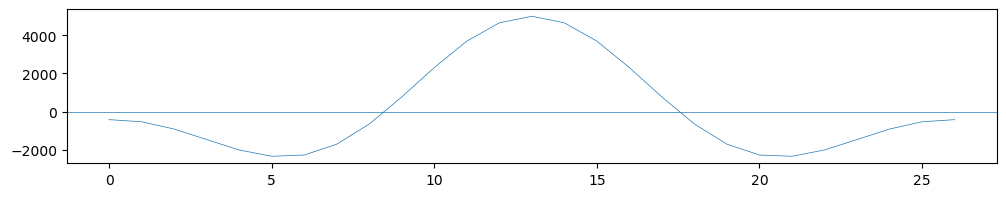

In [63]:
badfir = concatenate((dtd[-13:], dtd[:14])).real
plot(badfir)
axhline(0)
len(badfir)

So we multiply our desired impulse response elementwise with a finite-support
window function to improve its frequency-domain behavior.
(This is equivalent to multiplying our original gigantic impulse response with the window function,
and element-by-element multiplication in the time domain corresponds to convolution in the frequency
domain.)
There are lots of commonly used window functions,
but a reasonable default is the [Hamming window](https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows). 
This dramatically reduces the size of the discontinuities.

27

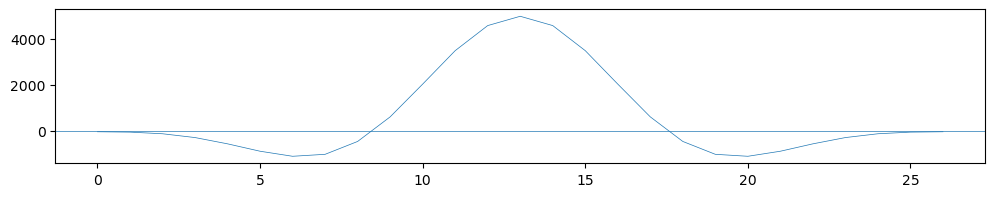

In [64]:
fir = hamming(len(badfir)) * badfir
plot(fir)
axhline(0)
len(fir)

This gives us a decent FIR filter kernel for the desired band, close to the best that can be done
with such small support.  However, we can see that this kernel has significant response at DC:

In [65]:
fir.mean()

647.8815132947595

We can remove that response at DC by brute force, but that reintroduces the discontinuity, which we can
remove again by windowing it again.  This rather crude process yields this kernel, whose response at DC is
not actually zero but is substantially smaller:

(array([  -8.77,  -10.41,  -15.57,  -25.09,  -40.73,  -66.16, -110.04,
        -194.61, -358.65, -575.44, -536.33,  265.8 , 1666.84, 2414.09,
        1666.84,  265.8 , -536.33, -575.44, -358.65, -194.61, -110.04,
         -66.16,  -40.73,  -25.09,  -15.57,  -10.41,   -8.77]),
 88.7313158986802)

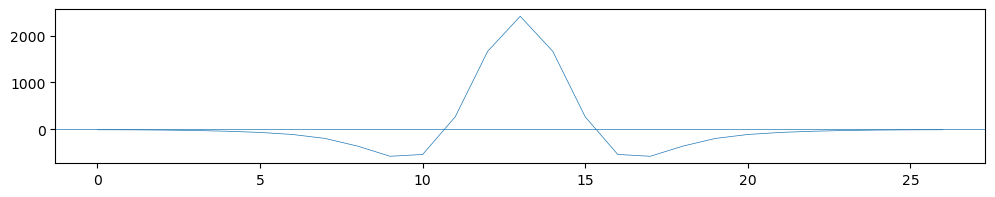

In [66]:
zdr = fir           # "zero" dc response FIR kernel
for i in range(10):
    zdr = hamming(len(zdr)) * (zdr - sum(zdr)/len(zdr))
plot(zdr)
axhline(0)
zdr.round(2), zdr.mean()

Because we've windowed our kernel down to a tiny time window, we can expect its frequency response to be pretty
blurred out.  Let's see what that blurred response looks for, first for the kernel with response at DC:

(0.0, 8000.0)

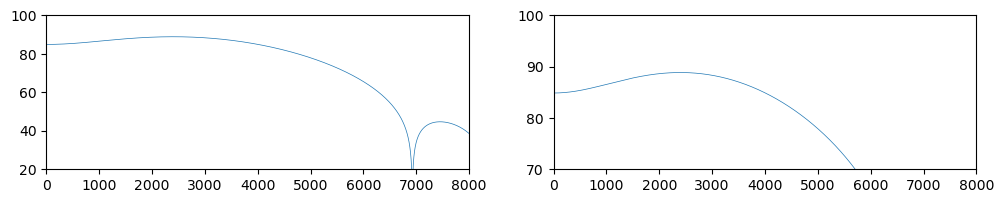

In [67]:
padded = zeros(44100)
padded[:len(fir)] = fir
firfr = abs(fft.fft(padded))**2
subplot(121); plot(log10(firfr)*10); ylim(20, 100); xlim(0, 8000)
subplot(122); plot(log10(firfr)*10); ylim(70, 100); xlim(0, 8000)

Then for the one who we attempted to beat into having zero response at DC:

(0.0, 8000.0)

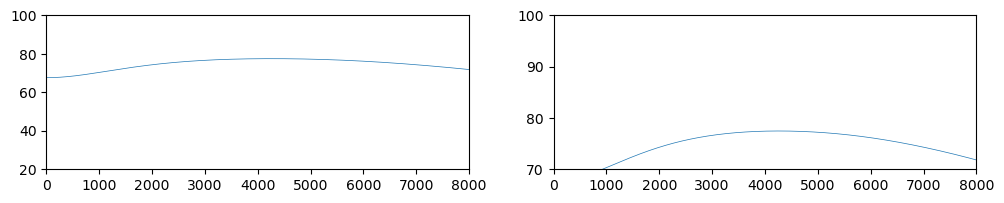

In [68]:
pzdr = zeros(44100)
pzdr[:len(zdr)] = zdr
zfr = abs(fft.fft(pzdr))**2
subplot(121); plot(log10(zfr)*10); ylim(20, 100); xlim(0, 8000)
subplot(122); plot(log10(zfr)*10); ylim(70, 100); xlim(0, 8000)


We can see what this does to our synthetic signal.  Numpy's default convolution behavior is to make the signal
bigger by the kernel size (minus one), so to get them to overlay properly we have to compensate.
We can see that, indeed, the frequencies of interest are almost untouched, but the noise is substantially
attenuated.

(1200.0, 1400.0)

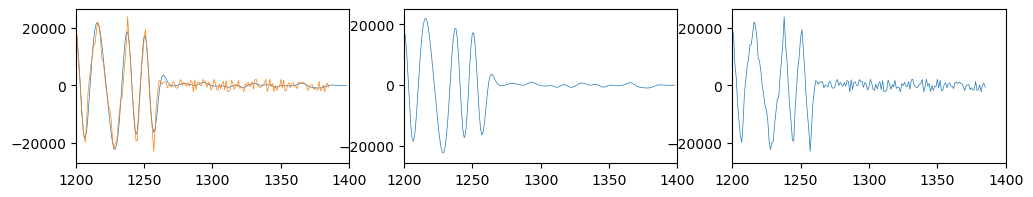

In [69]:
subplot(131); plot(convolve(fir, signal)[13:]); plot((signal*23000));xlim(1200, 1400)
subplot(132); plot(convolve(fir, signal)[13:]); xlim(1200, 1400)
subplot(133); plot((signal*23000));xlim(1200, 1400)

Trying these techniques on some real data
--------------

Originally I loaded this data from a 16-bit stereo .WAV file which I am not checking in.

In [70]:
import wave   # standard module included in the Python standard library since last millennium

def read_wav(filename):
    with wave.open(filename, 'r') as wf:
        assert wf.getnchannels() == wf.getsampwidth() == 2
        return frombuffer(wf.readframes(wf.getnframes()), '<i2')[::2]

Here is some audio data digitized at 44.1 ksps from a physical cassette tape using this format.
This part of the data has a problem: there's a click and the data is significantly attenuated from then on.
But both MAME and the Sord hardware are able to read this data successfully.  This encodes about 13 bytes of data,
mostly zero bytes; you can see there are 9 peaks of the zero tone in between each oscillation of the ones' tone,
which I think is the stop bit.
(It's possible I got the description above wrong and it's actually the start bit.)

3000

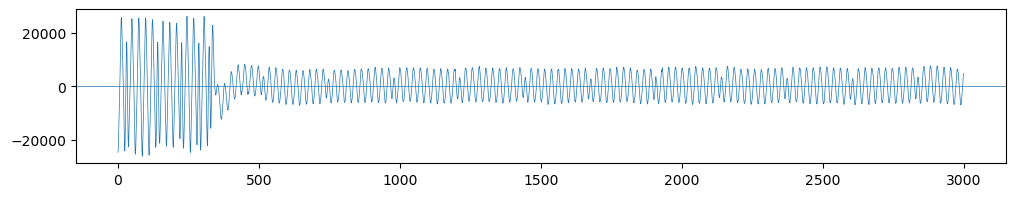

In [71]:
realdata = loadtxt('interesting.cassette')  # numpy savetxt/loadtxt are convenient here
plot(realdata)
axhline(0)
len(realdata)

There's a sudden step down, followed by attenuation of the signal, which is the sort of thing that makes it very difficult to demodulate data reliably.

array([-24553., -23272., -19559., ...,   1499.,   3157.,   4812.])

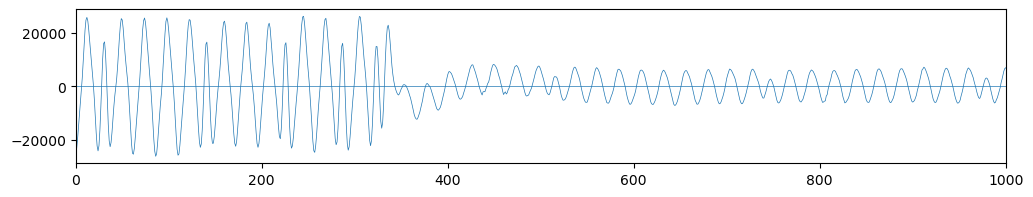

In [72]:
plot(realdata)
xlim(0, 1000)
axhline(0)
realdata

That peak during the step down almost didn't make it above the X-axis!
Let's see if our bandpass FIR filter cleans that up a little bit.

53

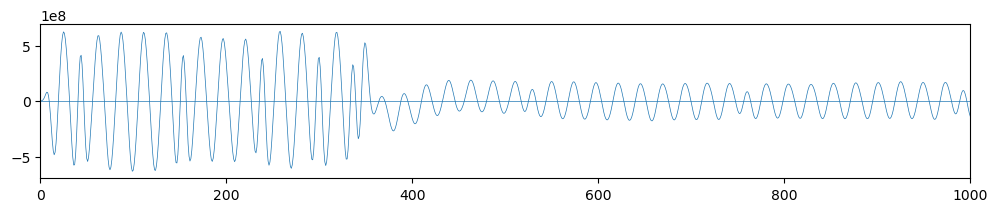

In [73]:
plot(convolve(fir, realdata))
xlim(0, 1000)
axhline(0)
53

That does look promising.  How about the other filter, the one which has less response at DC?

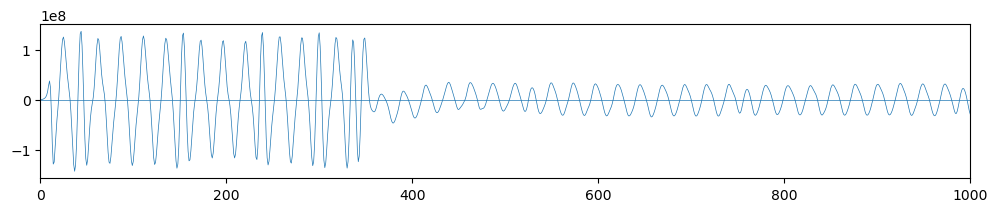

In [74]:
zdata = convolve(zdr, realdata)
plot(zdata); xlim(0, 1000); axhline(0); None

Possibly a better way to visualize this data is to plot its cube root, so that we can see both amplitudes of
oscillation conveniently on the same scale.

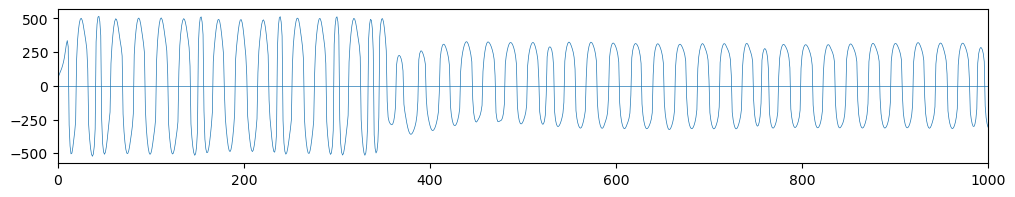

In [75]:
plot(cbrt(zdata)); xlim(0, 1000); axhline(0); None

Those look like significant improvements over the original data.  Let's see how our comb-filter-based scheme does
at demodulating the original, dirty data.

array([1.15090995e+14, 7.78274276e+13, 5.32372540e+13, ...,
       5.41492643e+13, 5.39524506e+13, 5.37702338e+13])

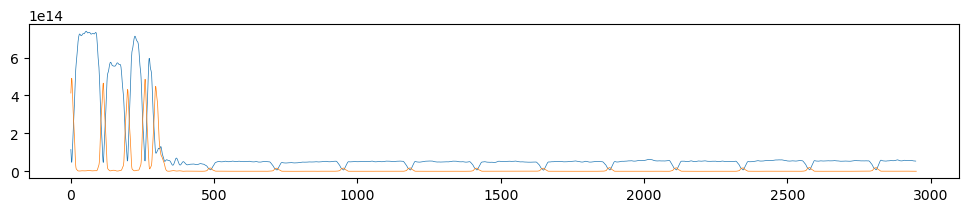

In [76]:
aoiz = filter_zero_power(zero_parabolic(realdata)**2)
aoio = filter_ones_power(ones_parabolic(realdata, 4)**2)
plot(aoiz)
plot(aoio*4)
aoiz

That looks like it's okay, but it's a little hard to see what's going on in the attenuated region.  If we log
the data it gets easier to see:

array([1.15090995e+14, 7.78274276e+13, 5.32372540e+13, ...,
       5.41492643e+13, 5.39524506e+13, 5.37702338e+13])

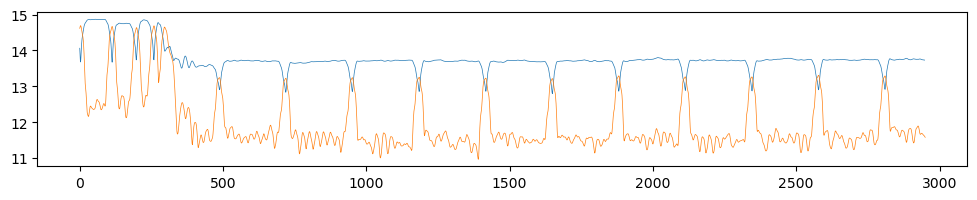

In [77]:
plot(log10(aoiz))
plot(log10(aoio*4))
aoiz

Ooh, now instead of an eye diagram or a kittycat diagram we have a ghost diagram.

What if we apply them to our filtered data instead?

array([1.25497529e+22, 1.27718929e+22, 1.26285643e+22, ...,
       9.89341493e+20, 9.22383113e+20, 8.63246540e+20])

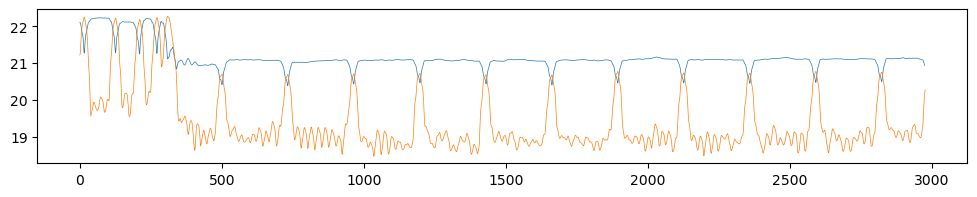

In [78]:
zz = filter_zero_power(zero_parabolic(zdata)**2)
zo = filter_ones_power(ones_parabolic(zdata, 4)**2)
plot(log10(zz))
plot(log10(zo*4))
zz

I feel like that might be a little better at handling the interference from the discontinuity.

Demodulating data with direct-form FIR filtering
---------------------

Suppose we just take the Fourier and Hamming approach to detecting each of the tones?  Let's look for sine waves,
not cosine waves.

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j])

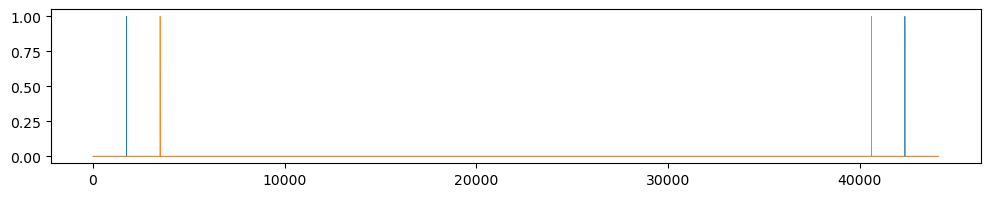

In [90]:
f0f = zeros(44100, complex)     # frequency of the 0 tone in the frequency domain
f1f = f0f.copy()
f0f[1750] = f1f[3500] = 1j
f0f[22051:] = f0f[22049:0:-1].conj()   # I lied, they don't have to be symmetric, but conjugate-symmetric
f1f[22051:] = f1f[22049:0:-1].conj()
plot(abs(f0f))
plot(abs(f1f))
f0f

array([ 0.        ,  0.4935148 ,  0.95650796, ..., -1.36034548,
       -0.95650796, -0.4935148 ])

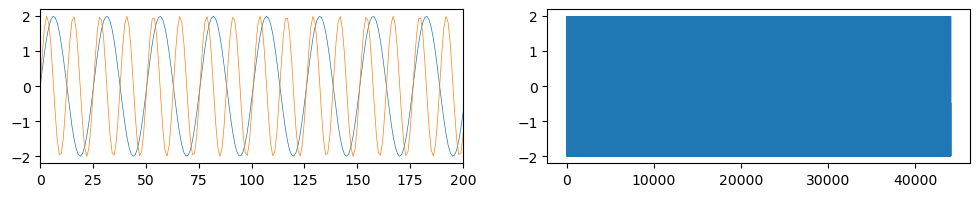

In [91]:
f0td = fft.fft(f0f).real
f1td = fft.fft(f1f).real
subplot(121); plot(f0td); plot(f1td); xlim(0, 200)
subplot(122); plot(f0td)
f0td

So now we want to window those, as before, down to support of about 25 or 27 samples.

array([ 0.02, -0.03, -0.1 , -0.24, -0.44, -0.69, -0.95, -1.19, -1.33,
       -1.35, -1.2 , -0.91, -0.49,  0.  ,  0.49,  0.91,  1.2 ,  1.35,
        1.33,  1.19,  0.95,  0.69,  0.44,  0.24,  0.1 ,  0.03, -0.02])

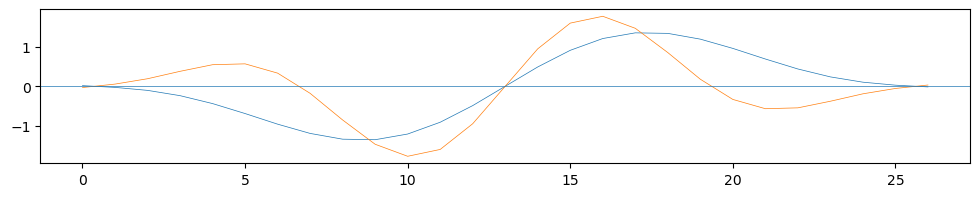

In [81]:
def window_td(td, size, window=hamming):
    n = (size - 1) // 2
    return window(size) * concatenate((td[-n:], td[:n+1])).real

f0w = window_td(f0td, 27)
f1w = window_td(f1td, 27)
plot(f0w)
plot(f1w)
axhline(0)
f0w.round(2)

(Plausibly this is a case where we would prefer using the triangular window instead of the Hamming window,
because our top priority is detecting transitions between these tones in the time domain.  Maybe even the Dirichlet
window, also known as the boxcar window or no fucking window function at all, would be better.)

We can see that these look kind of similar to the impulse responses of the filter cascades we had rigged up earlier.
What do they look like in the frequency domain?

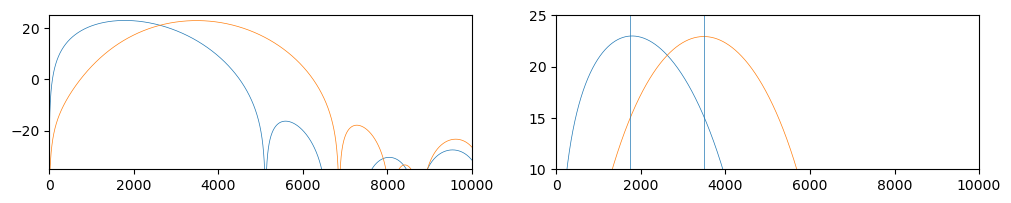

In [82]:
dbf0 = log10(abs(fft.fft(concatenate((f0w, zeros(44100-len(f0w))))))**2)*10
dbf1 = log10(abs(fft.fft(concatenate((f1w, zeros(44100-len(f1w))))))**2)*10
subplot(121); plot(dbf0); plot(dbf1); ylim(-35, 25); xlim(0, 10000)
subplot(122); plot(dbf0); plot(dbf1); ylim(10, 25); xlim(0, 10000); axvline(1750); axvline(3500)

Hmm, although those center frequencies are pretty great, that doesn't seem like great separation.
But these are supposed to be nearly optimal.  So maybe they'll be better than what we had before?

array([-0.00055764,  0.00501452,  0.00010931, ..., -0.00184822,
       -0.00133354,  0.00043525])

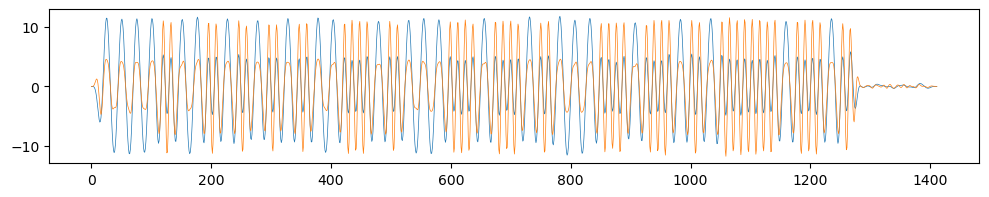

In [83]:
s0 = convolve(f0w, signal)
s1 = convolve(f1w, signal)
plot(s0)
plot(s1)
s0

That doesn't look *bad*.  We can run it through the same smoothing as the others:

array([3.10967835e-07, 2.51454469e-05, 1.19487184e-08, ...,
       3.41590287e-06, 1.77831973e-06, 1.89444179e-07])

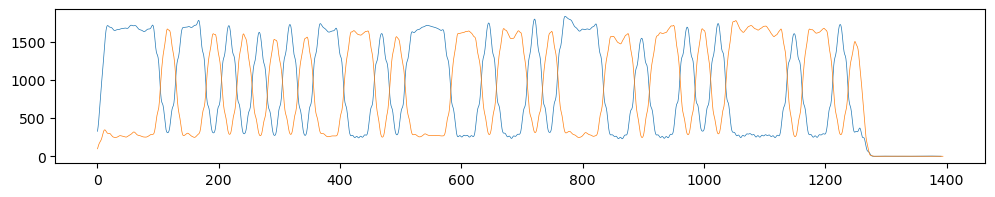

In [84]:
plot(filter_zero_power(s0**2))
plot(filter_ones_power(s1**2))
s0**2

That looks pretty decent, although the noise floor is a lot higher; as plotted in the frequency domain earlier,
each of these
supposedly-optimal filter kernels
has substantial response at the other's frequency, because when we broadened out their frequency response
with the Hamming window, we didn't constrain them to have a notch there.  We could probably improve them
with the same feedforward comb we were using before to get that notching.

What does this look like on the real data?

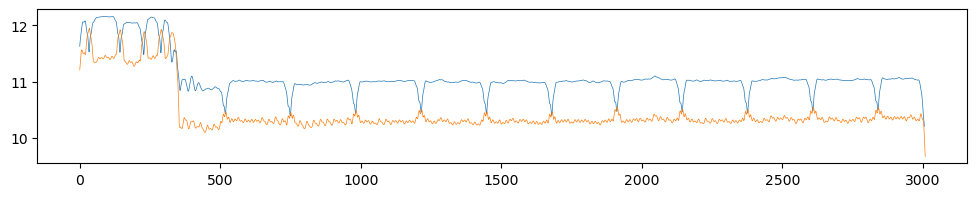

In [85]:
plot(log10(filter_zero_power(convolve(f0w, realdata)**2)))
plot(log10(filter_ones_power(convolve(f1w, realdata)**2)))
None

This is actually more than an order of magnitude worse, probably due to the missing notch filter; remember, this is what we had with the goofy comb and fractional delay filter cascade:

array([1.25497529e+22, 1.27718929e+22, 1.26285643e+22, ...,
       9.89341493e+20, 9.22383113e+20, 8.63246540e+20])

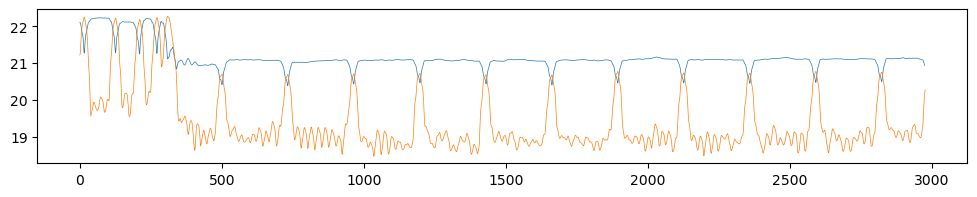

In [86]:
plot(log10(zz))
plot(log10(zo*4))
zz